# Load DWD data

Support provided for [ICON](https://www.dwd.de/EN/research/weatherforecasting/num_modelling/01_num_weather_prediction_modells/icon_description.html) via the [DWD Open Data Server](https://opendata.dwd.de/). This includes interfaces for accessing global forecasts and high-resolution regional forecasts for Europe (ICON-EU) and Germany (ICON-D2).

Note that the current operational version of ICON uses a single-moment microphysics scheme that [underestimates relative humidity in ice-supersaturated regions](https://doi.org/10.5194/egusphere-2025-3312). This notebook will be updated when the double-moment microphysics scheme currently under development becomes operational.

No credentials are required to use the DWD Open Data Server.

**Tools for accessing DWD data are not throughly tested in CI because they are vulnerable to upstream changes to the DWD Open Data Server.** If you think you have found a problem please [open an issue](https://github.com/contrailcirrus/pycontrails/issues)!

## Forecast availability

The DWD Open Data Server provides access to recent forecasts (typically those initialized within the last 24 hours) but does not provide a long-term forecast archive.

In [1]:
from pycontrails.datalib.dwd import ods

Global forecasts are initialized at 0z, 6z, 12z, and 18z. They provide hourly data out to 78 hours and three-hourly data thereafter (out to 180 hours for the 0z and 12z runs and 120 hours for the 6z and 18z runs).

In [2]:
ods.list_forecasts("global")

[datetime.datetime(2025, 11, 14, 0, 0),
 datetime.datetime(2025, 11, 14, 6, 0),
 datetime.datetime(2025, 11, 14, 12, 0),
 datetime.datetime(2025, 11, 14, 18, 0)]

Regional forecasts are initialized every three hours. ICON-EU forecasts initialized and 0z, 6z, 12z, and 18z provide hourly data out to 78 hours and three-hourly data out to 120 hours. Other ICON-EU forecasts provide hourly data out to 30 hours. ICON-D2 forecasts provide hourly data out to 48 hours.

In [3]:
ods.list_forecasts("europe")

[datetime.datetime(2025, 11, 13, 21, 0),
 datetime.datetime(2025, 11, 14, 0, 0),
 datetime.datetime(2025, 11, 14, 3, 0),
 datetime.datetime(2025, 11, 14, 6, 0),
 datetime.datetime(2025, 11, 14, 9, 0),
 datetime.datetime(2025, 11, 14, 12, 0),
 datetime.datetime(2025, 11, 14, 15, 0),
 datetime.datetime(2025, 11, 14, 18, 0)]

In [4]:
ods.list_forecasts("germany")

[datetime.datetime(2025, 11, 14, 0, 0),
 datetime.datetime(2025, 11, 14, 3, 0),
 datetime.datetime(2025, 11, 14, 6, 0),
 datetime.datetime(2025, 11, 14, 9, 0),
 datetime.datetime(2025, 11, 14, 12, 0),
 datetime.datetime(2025, 11, 14, 15, 0),
 datetime.datetime(2025, 11, 14, 18, 0),
 datetime.datetime(2025, 11, 14, 21, 0)]

## Global ICON

Global ICON output is retrieved on the model's native icosahedral grid and remapped after retrieval to a regular latitude-longitude grid using a nearest-neighbor algorithm. (Support for other remapping algorithms may be added in future releases). The resolution of the latitude-longitude grid is set to 0.25 degrees by default, which provides resolution comparable to the model's native icosahedral grid at midlatitudes. This default can be overridden using the `grid` parameter.

Three-dimensional fields are retrieved on model levels and interpolated after retrieval to an arbitrary set of pressure levels. By default, fields are interpolated to standard flight levels between barometric altitudes of 20,000 and 50,000 ft.

A specific forecast cycle can be selected using the `forecast_time` parameter:

In [24]:
from pycontrails.datalib.dwd import ICON

In [25]:
icon = ICON(
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    forecast_time="2025-11-14 00:00",
    variables=("t", "q"),
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['t', 'q']
	Pressure levels: [116, 122, 128, 134, 141, 147, 155, 162, 170, 179, 188, 197, 206, 217, 227, 238, 250, 262, 274, 287, 301, 315, 329, 344, 360, 376, 393, 410, 428, 446, 466]
	Grid: 0.25
	Domain: global
	Forecast time: 2025-11-14 00Z
	Steps: [12, 13, 14, 15]

Otherwise, the forecast cycle that provides the shortest lead time is selected automatically:

In [26]:
icon = ICON(
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("t", "q"),
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['t', 'q']
	Pressure levels: [116, 122, 128, 134, 141, 147, 155, 162, 170, 179, 188, 197, 206, 217, 227, 238, 250, 262, 274, 287, 301, 315, 329, 344, 360, 376, 393, 410, 428, 446, 466]
	Grid: 0.25
	Domain: global
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [27]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 1GB
Dimensions:            (longitude: 1441, latitude: 721, level: 31, time: 4)
Coordinates:
  * longitude          (longitude) float64 12kB -180.0 -179.8 ... 179.8 180.0
  * latitude           (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * level              (level) float64 248B 116.0 122.0 128.0 ... 446.0 466.0
  * time               (time) datetime64[ns] 32B 2025-11-14T12:00:00 ... 2025...
    air_pressure       (level) float32 124B 1.16e+04 1.22e+04 ... 4.66e+04
    altitude           (level) float32 124B 1.524e+04 1.492e+04 ... 6.09e+03
Data variables:
    air_temperature    (longitude, latitude, level, time) float32 515MB dask.array<chunksize=(1441, 721, 31, 1), meta=np.ndarray>
    specific_humidity  (longitude, latitude, level, time) float32 515MB dask.array<chunksize=(1441, 721, 31, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:34 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON
    product:                 forecast

In [28]:
import cartopy.crs as ccrs

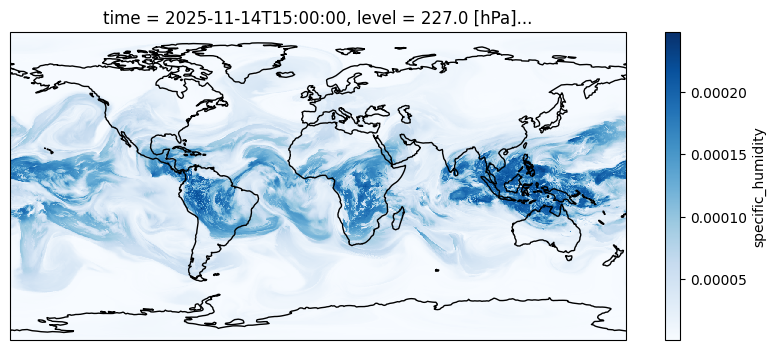

In [32]:
mds["specific_humidity"].data[..., 14, -1].T.plot(
    figsize=(10, 4),
    cmap="Blues",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

Top-of-atmosphere radiative fluxes can be retrieved by setting `pressure_levels=-1`. Fluxes are provided as averages over the previous hour, so the time coordinate is shifted backward by 30 minutes relative to three-dimensional fields.

In [33]:
icon = ICON(
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("rlut", "rst"),
    pressure_levels=-1,
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['rlut', 'rst']
	Pressure levels: [-1]
	Grid: 0.25
	Domain: global
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [34]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 25MB
Dimensions:                          (level: 1, time: 3, latitude: 721,
                                      longitude: 1441)
Coordinates:
  * level                            (level) float64 8B -1.0
  * time                             (time) datetime64[ns] 24B 2025-11-14T12:...
  * latitude                         (latitude) float64 6kB -90.0 ... 90.0
  * longitude                        (longitude) float64 12kB -180.0 ... 180.0
Data variables:
    toa_net_downward_shortwave_flux  (longitude, latitude, level, time) float32 12MB dask.array<chunksize=(1441, 721, 1, 1), meta=np.ndarray>
    toa_outgoing_longwave_flux       (longitude, latitude, level, time) float32 12MB dask.array<chunksize=(1441, 721, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:39 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON
    product:                 forecast

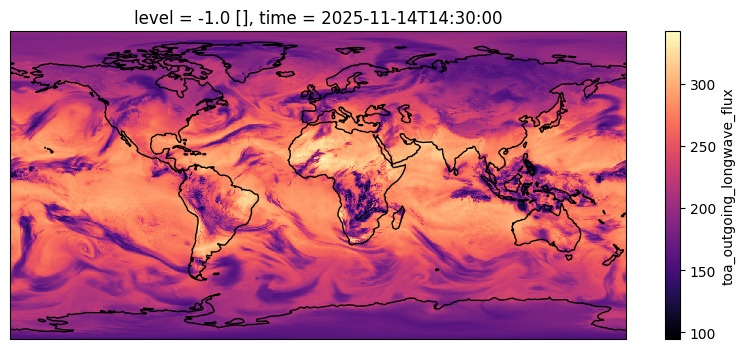

In [35]:
mds["toa_outgoing_longwave_flux"].data[..., 0, -1].T.plot(
    figsize=(10, 4),
    cmap="magma",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

## Regional ICON-EU

ICON-EU output is retrieved on a regular latitude-longitude grid, so no remapping is required and a warning is issued if a value is provided for `grid`. The interface is otherwise identical to the interface for global ICON forecasts.

In [36]:
icon = ICON(
    domain="europe",
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("t", "q"),
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['t', 'q']
	Pressure levels: [116, 122, 128, 134, 141, 147, 155, 162, 170, 179, 188, 197, 206, 217, 227, 238, 250, 262, 274, 287, 301, 315, 329, 344, 360, 376, 393, 410, 428, 446, 466]
	Grid: None
	Domain: europe
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [37]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 897MB
Dimensions:            (longitude: 1377, latitude: 657, level: 31, time: 4)
Coordinates:
  * longitude          (longitude) float64 11kB -23.5 -23.44 ... 62.44 62.5
  * latitude           (latitude) float64 5kB 29.5 29.56 29.62 ... 70.44 70.5
  * level              (level) float64 248B 116.0 122.0 128.0 ... 446.0 466.0
  * time               (time) datetime64[ns] 32B 2025-11-14T12:00:00 ... 2025...
    air_pressure       (level) float32 124B 1.16e+04 1.22e+04 ... 4.66e+04
    altitude           (level) float32 124B 1.524e+04 1.492e+04 ... 6.09e+03
Data variables:
    air_temperature    (longitude, latitude, level, time) float32 449MB dask.array<chunksize=(1377, 657, 31, 1), meta=np.ndarray>
    specific_humidity  (longitude, latitude, level, time) float32 449MB dask.array<chunksize=(1377, 657, 31, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:41 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON-EU
    product:                 forecast

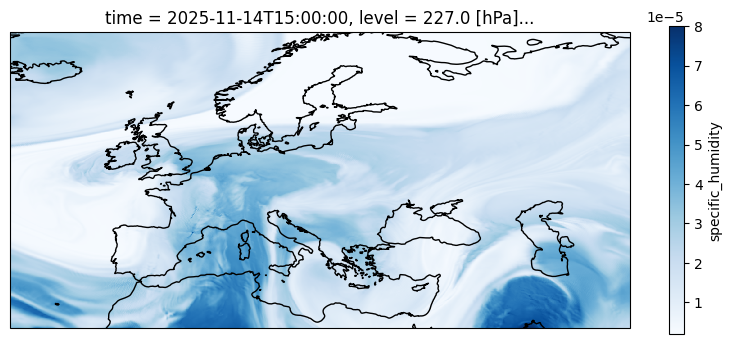

In [38]:
mds["specific_humidity"].data[..., 14, -1].T.plot(
    figsize=(10, 4),
    cmap="Blues",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

In [39]:
icon = ICON(
    domain="europe",
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("rlut", "rst"),
    pressure_levels=-1,
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['rlut', 'rst']
	Pressure levels: [-1]
	Grid: None
	Domain: europe
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [40]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 22MB
Dimensions:                          (level: 1, time: 3, latitude: 657,
                                      longitude: 1377)
Coordinates:
  * level                            (level) float64 8B -1.0
  * time                             (time) datetime64[ns] 24B 2025-11-14T12:...
  * latitude                         (latitude) float64 5kB 29.5 29.56 ... 70.5
  * longitude                        (longitude) float64 11kB -23.5 ... 62.5
Data variables:
    toa_outgoing_longwave_flux       (longitude, latitude, level, time) float32 11MB dask.array<chunksize=(1377, 657, 1, 1), meta=np.ndarray>
    toa_net_downward_shortwave_flux  (longitude, latitude, level, time) float32 11MB dask.array<chunksize=(1377, 657, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:43 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON-EU
    product:                 forecast

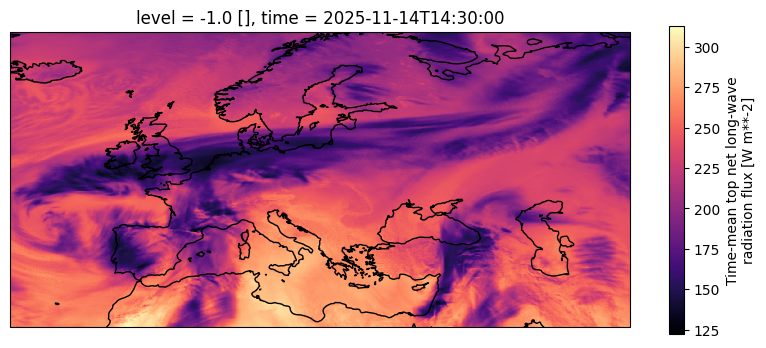

In [41]:
mds["toa_outgoing_longwave_flux"].data[..., 0, -1].T.plot(
    figsize=(10, 4),
    cmap="magma",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

## Regional ICON-D2

The interface for ICON-D2 is identical to ICON-EU.

In [42]:
icon = ICON(
    domain="germany",
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("t", "q"),
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['t', 'q']
	Pressure levels: [116, 122, 128, 134, 141, 147, 155, 162, 170, 179, 188, 197, 206, 217, 227, 238, 250, 262, 274, 287, 301, 315, 329, 344, 360, 376, 393, 410, 428, 446, 466]
	Grid: None
	Domain: germany
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [43]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 899MB
Dimensions:            (longitude: 1215, latitude: 746, level: 31, time: 4)
Coordinates:
  * longitude          (longitude) float64 10kB -3.94 -3.92 -3.9 ... 20.32 20.34
  * latitude           (latitude) float64 6kB 43.18 43.2 43.22 ... 58.06 58.08
  * level              (level) float64 248B 116.0 122.0 128.0 ... 446.0 466.0
  * time               (time) datetime64[ns] 32B 2025-11-14T12:00:00 ... 2025...
    air_pressure       (level) float32 124B 1.16e+04 1.22e+04 ... 4.66e+04
    altitude           (level) float32 124B 1.524e+04 1.492e+04 ... 6.09e+03
Data variables:
    air_temperature    (longitude, latitude, level, time) float32 450MB dask.array<chunksize=(1215, 746, 31, 1), meta=np.ndarray>
    specific_humidity  (longitude, latitude, level, time) float32 450MB dask.array<chunksize=(1215, 746, 31, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:43 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON-D2
    product:                 forecast

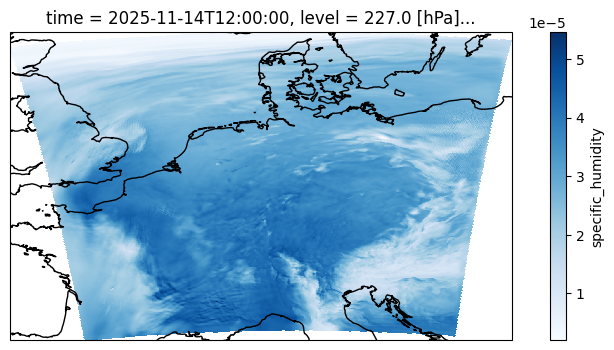

In [44]:
mds["specific_humidity"].data[..., 14, 0].T.plot(
    figsize=(10, 4),
    cmap="Blues",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

In [45]:
icon = ICON(
    domain="germany",
    time=("2025-11-14 12:00", "2025-11-14 15:00"),
    variables=("rlut", "rst"),
    pressure_levels=-1,
)
icon

ICON
	Timesteps: ['2025-11-14 12', '2025-11-14 13', '2025-11-14 14', '2025-11-14 15']
	Variables: ['rlut', 'rst']
	Pressure levels: [-1]
	Grid: None
	Domain: germany
	Forecast time: 2025-11-14 12Z
	Steps: [0, 1, 2, 3]

In [46]:
mds = icon.open_metdataset()
mds

MetDataset with data:

<xarray.Dataset> Size: 22MB
Dimensions:                          (level: 1, time: 3, latitude: 746,
                                      longitude: 1215)
Coordinates:
  * level                            (level) float64 8B -1.0
  * time                             (time) datetime64[ns] 24B 2025-11-14T12:...
  * latitude                         (latitude) float64 6kB 43.18 43.2 ... 58.08
  * longitude                        (longitude) float64 10kB -3.94 ... 20.34
Data variables:
    toa_outgoing_longwave_flux       (longitude, latitude, level, time) float32 11MB dask.array<chunksize=(1215, 746, 1, 1), meta=np.ndarray>
    toa_net_downward_shortwave_flux  (longitude, latitude, level, time) float32 11MB dask.array<chunksize=(1215, 746, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2025-11-14T22:45 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.59.1.dev2
    provider:                DWD
    dataset:                 ICON-D2
    product:                 forecast

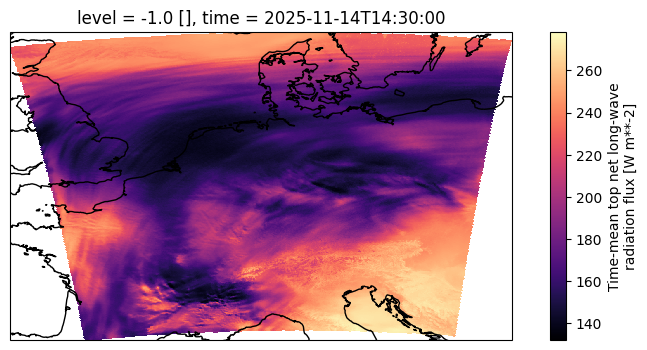

In [47]:
mds["toa_outgoing_longwave_flux"].data[..., 0, -1].T.plot(
    figsize=(10, 4),
    cmap="magma",
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();

## Using DWD data with CoCiP

The DWD Open Data Server provides *almost* all the fields requires to run CoCiP. The exception is vertical velocity: CoCiP expects vertical velocity to be provided in pressure coordinates (units of Pa/s), while the Open Data Server provides vertical velocities in height coordinates (units of m/s). As a workaround, height-coordinate vertical velocity can be converted *approximately* to pressure-coordinate vertical velocity using the hydrostatic relation. (This conversion is most accurate at large scales; see e.g. section 3.5 of [An Introduction to Dynamic Meteorology](https://isbnsearch.org/isbn/9780123848666) for details.)

Retrieve required fields, including height-coordinate vertical velocity:

In [18]:
icon = ICON(
    time=("2025-11-14 12:00", "2025-11-15 00:00"),
    variables=("t", "q", "u", "v", "wz", "cli"),
)
met = icon.open_metdataset()

In [19]:
icon = ICON(
    time=("2025-11-14 12:00", "2025-11-15 00:00"), variables=("rlut", "rst"), pressure_levels=-1
)
rad = icon.open_metdataset()

Convert approximately to pressure-coordinate vertical velocity:
$$\omega \approx -\rho g w = -\frac{p g w}{RT}$$

In [20]:
from pycontrails.physics import constants

In [ ]:
w = met["upward_air_velocity"].data
p = met["air_pressure"].data.broadcast_like(w)
T = met["air_temperature"].data
met["lagrangian_tendency_of_air_pressure"] = -p * constants.g * w / (constants.R_d * T)

Run gridded CoCiP

In [ ]:
import numpy as np

from pycontrails.core import MetDataset
from pycontrails.models.cocipgrid import CocipGrid
from pycontrails.models.humidity_scaling import ConstantHumidityScaling
from pycontrails.models.ps_model import PSGrid
from pycontrails.physics import units

In [ ]:
params = {
    "dt_integration": np.timedelta64(5, "m"),
    "max_age": np.timedelta64(10, "h"),
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=1.0),
    "aircraft_performance": PSGrid(),
}

source = MetDataset.from_coords(
    level=units.ft_to_pl(35_000),
    time="2025-11-14 13:00",
    longitude=met["longitude"].values,
    latitude=met["latitude"].values,
)

cocip_grid = CocipGrid(met=met, rad=rad, params=params)
result = cocip_grid.eval(source)

Plot results

In [53]:
import matplotlib.colors

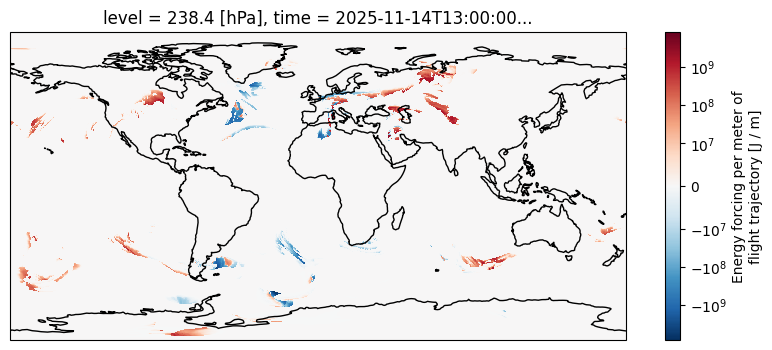

In [54]:
result["ef_per_m"].data.T.plot(
    figsize=(10, 4),
    cmap="RdBu_r",
    norm=matplotlib.colors.SymLogNorm(linthresh=1e7),
    subplot_kws=dict(projection=ccrs.PlateCarree(), transform=ccrs.PlateCarree()),
).axes.coastlines();